# MovieLens Recommender System Using Alternating Least Squares

In [35]:
import pandas as pd
import itertools
from pprint import pprint
from collections import defaultdict

from src.algorithms.alternating_least_squares import AlternatingLeastSquares
from src.helpers.dataset_indexer import DatasetIndexer
from src.helpers.checkpoint_manager import CheckpointManager
from src.recommenders import CollaborativeFilteringRecommenderBuilder
from src.backends import Backend
from src.helpers._logging import logger  # noqa
from src.settings import settings
from src.utils import vocabulary_based_one_hot_encode


In [36]:
USER_HEADER = "userId"
ITEM_HEADER = "movieId"
RATING_HEADER = "rating"
FEATURE_TO_ENCODE = "genres"

# https://files.grouplens.org/datasets/movielens/ml-32m-README.html
ITEM_FEATURE_LIST = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "IMAX",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]


In [37]:
CSV_FILES_DIR = "../../ml-32m/" # The dataset subfolder


In [38]:

# Import the movies csv file joined with the movie links csv file and that will act
# as our movie database. The backend needs this database to query the movies.
item_database = (
    pd.read_csv(f"{CSV_FILES_DIR}/movies.csv", dtype={ITEM_HEADER: str})
    .merge(
        pd.read_csv(f"{CSV_FILES_DIR}/links.csv", dtype={ITEM_HEADER: str}),
        on=ITEM_HEADER,
        how="left",
    )
    .assign(
        genres=lambda df: df[FEATURE_TO_ENCODE].apply(
            lambda genres: genres.split("|")
        ),
        features_hot_encoded=lambda df: df[FEATURE_TO_ENCODE].apply(
            lambda g: vocabulary_based_one_hot_encode(
                words=g, vocabulary=ITEM_FEATURE_LIST
            )
        ),
        features_count=lambda df: df["features_hot_encoded"].apply(lambda x: sum(x)),
    )
    .set_index(ITEM_HEADER)  # Set the movieId as the index
    .to_dict(orient="index")  # Convert the DataFrame to a dictionary
)

In [39]:
dataset_indexer = DatasetIndexer(
    # Path to the ratings.csv file
    file_path=f"{CSV_FILES_DIR}/ratings.csv",
    user_header=USER_HEADER,
    item_header=ITEM_HEADER,
    rating_header=RATING_HEADER,
    limit=1_000_000,

    # limit=settings.general.LINES_COUNT_TO_READ,
)

# Create an indexed dataset object
indexed_data = dataset_indexer.index_simple(
    approximate_train_ratio=settings.general.APPROXIMATE_TRAIN_RATIO
)

2025-01-25 02:48:05,631 [WARNING] The current implementation does not split the data into train and test sets exactly with the provided ratio. We use the provided ratio as a probability for a Bernoulli distribution to know whether a given data point should be used as a training data or a test data.
2025-01-25 02:48:05,633 [INFO] The file ../../ml-32m//ratings.csv to (simple) index has been opened successfully, starting reading its lines...
2025-01-25 02:48:12,782 [WARNING] The limit of lines (.i.e 1000000) to index has been reached. Exiting without loading the rest... 
2025-01-25 02:48:12,783 [INFO] Successfully indexed 1000000 lines from ../../ml-32m//ratings.csv


In [40]:
als_instance = AlternatingLeastSquares(
    hyper_lambda=settings.als.HYPER_LAMBDA,
    hyper_gamma=settings.als.HYPER_GAMMA,
    hyper_tau=settings.als.HYPER_TAU,
    hyper_n_epochs=settings.als.HYPER_N_EPOCH,
    hyper_n_factors=settings.als.HYPER_N_FACTOR,
)

als_backend = Backend(
    # Define the algorithm
    algorithm=als_instance,
    checkpoint_manager=CheckpointManager(
        checkpoint_folder=settings.als.CHECKPOINT_FOLDER,
        sub_folder=str(settings.general.LINES_COUNT_TO_READ),
    ),
    # The predictor needs this to render the name of the items
    item_database=item_database,
    # Whether we should resume by using the last state of
    # the algorithm the checkpoint manager folder or not.
    resume=True,
    save_checkpoint=False,
)


In [41]:
recommender_builder = CollaborativeFilteringRecommenderBuilder(
    backend=als_backend,
)


In [42]:
# Harry Potter Items (genres : Fantasy, Adventure, Children, Mystery, Thriller)
harry_potter_ids = [
    "4896", "5816", "8368", "40815", "54001", "69844", "81834", "88125", "186777", "247038", "267654"
]

# Lord of the Rings Items (genres : Fantasy, Adventure, Documentary, Action, Animation, Children)
lord_of_the_rings_ids = [
    "2116", "4993", "5952", "7153", "231829", "267392"
]

harry_potter_and_lord_of_the_rings_set = {
    # Harry Potter (Fantasy, Adventure, Children, Mystery, Thriller, IMAX) 
    "4896", "5816", "8368", "40815", "54001", "69844", "81834", "88125", "186777", "247038", "267654",

    # Lord of the Rings Items (Fantasy, Adventure, Documentary, Action, Animation, Children)
    "2116", "4993", "5952", "7153", "231829", "267392",
}



In [43]:
# Retrieve some movies for PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb


items_per_genre_for_embedding_plot = defaultdict(set)
max_per_genre= 15
item_limit_to_scan = 20000
# We don't want to count the item from `harry_potter_and_lord_of_the_rings_set`
items_count = -len(harry_potter_and_lord_of_the_rings_set)
for items in [harry_potter_and_lord_of_the_rings_set, item_database.keys()]:
    for item in items:
        items_count += 1
        
        if items_count == item_limit_to_scan:
            logger.info(f"Item count limit reached while choosing the item to plot as embedding, exiting..")
            break
            
        if not (data:= item_database.get(item)):
            logger.warning(f"Cannot find item {item} in the item database, skipping...")
            continue
        for genre in data["genres"]:
            if len(items_per_genre_for_embedding_plot[genre]) == max_per_genre:
                continue
            items_per_genre_for_embedding_plot[genre].add(item)
            
    
 
    

2025-01-25 02:48:13,489 [INFO] Item count limit reached while choosing the item to plot as embedding, exiting..


In [44]:
ll = list(itertools.chain(*items_per_genre_for_embedding_plot.values()))

In [45]:
# This might take some moment before finishing
# Here is where the model is actually trained
recommender = recommender_builder.build(
    data=indexed_data, 
    item_database=item_database, 
    # Whether to include feature functionality or not
    include_features=True
)

2025-01-25 02:48:13,709 [INFO] Starting the build of the recommender using AlternatingLeastSquares with the state {'hyper_lambda': 0.1, 'hyper_tau': 0.1, 'hyper_gamma': 0.1, 'hyper_n_epochs': 20, 'hyper_n_factors': 40, 'user_factors': None, 'item_factors': None, 'user_biases': None, 'item_biases': None, 'feature_factors': None, 'loss_train': [], 'loss_test': [], 'rmse_train': [], 'rmse_test': []}
2025-01-25 02:48:13,712 [INFO] Starting a model fitting using the backend AlternatingLeastSquares...
2025-01-25 02:48:13,812 [INFO] Checkpoint /home/hjisaac/AI4Science/ml_at_scale/./artifacts/checkpoints/als/1000000000/20250124-044700_lambda0.1_gamma0.1_tau0.1_n_epochs20_n_factors40.pkl loaded with success
2025-01-25 02:48:13,814 [INFO] All factors and biases are already provided, so no initialization is needed.
2025-01-25 02:48:13,814 [INFO] About to start training with the `include_features` parameter set to True.
2025-01-25 02:48:13,816 [ERROR] Cannot train the model more because hyperparam

In [46]:

def plot_movie_user_pca(movie_vectors, movie_genres, user_vectors, genres_list):
    """
    Plots PCA-reduced movie and user latent vectors with movie genres visualized as blended colors.
    
    Args:
        movie_vectors (numpy.ndarray): Latent factors for movies (shape: [num_movies, latent_dim]).
        movie_genres (list of lists): A list where each element is a list of genres for the corresponding movie.
        user_vectors (numpy.ndarray): Latent factors for users (shape: [num_users, latent_dim]).
        genres_list (list): List of all unique genres (e.g., ['Action', 'Comedy', 'Drama']).
    """
    # Map genres to unique colors
    genre_colors = {genre: to_rgb(color) for genre, color in zip(genres_list, plt.cm.tab10.colors)}

    # Compute blended colors for movies with multiple genres
    movie_colors = [
        np.mean([genre_colors[genre] for genre in genres], axis=0) for genres in movie_genres
    ]

    # Combine data for PCA
    combined_data = np.vstack((user_vectors, movie_vectors))

    # Apply PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(combined_data)

    # Split the reduced data back into users and movies
    reduced_user_vectors = reduced_data[:len(user_vectors)]
    reduced_movie_vectors = reduced_data[len(user_vectors):]

    # Plot users
    plt.figure(figsize=(10, 8))
    plt.scatter(
        reduced_user_vectors[:, 0],
        reduced_user_vectors[:, 1],
        color='blue',
        alpha=0.5,
        label='Users'
    )

    # Plot movies with blended colors based on genres
    for idx, color in enumerate(movie_colors):
        plt.scatter(
            reduced_movie_vectors[idx, 0],
            reduced_movie_vectors[idx, 1],
            color=color,
            alpha=0.8
        )

    # Add title, labels, and legend
    plt.title('PCA Reduction with Multi-Genre Movies')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(['Users', 'Movies'], loc='upper right')
    plt.show()


/tmp/ipykernel_82692/4057916413.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color=color, cmap='viridis', edgecolor='k')


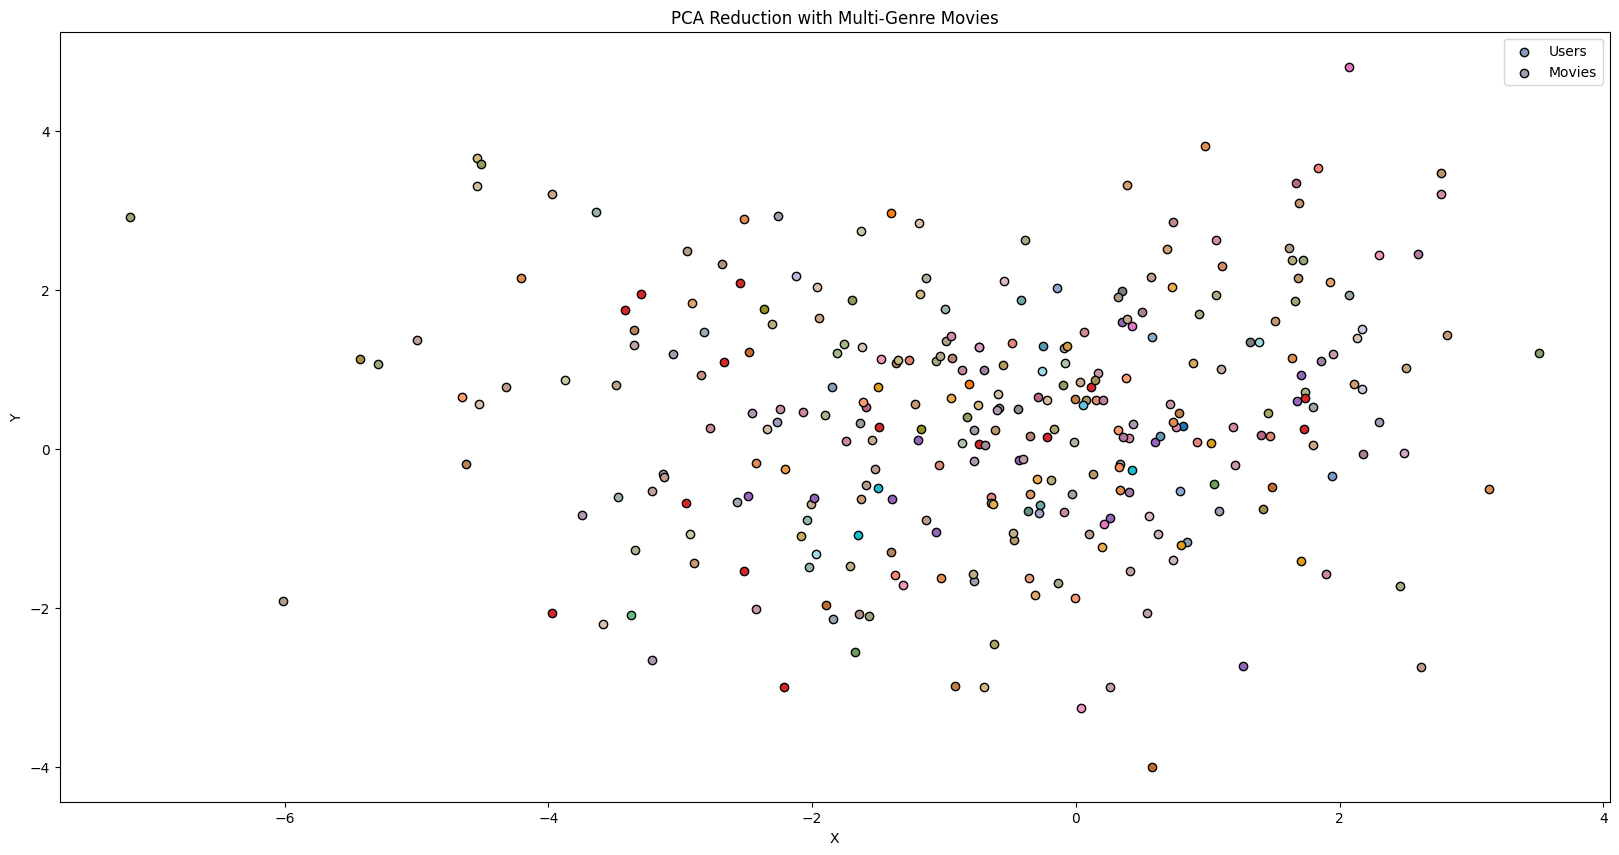

In [58]:
# Trial

genre_colors = {genre: to_rgb(color) for genre, color in zip(items_per_genre_for_embedding_plot.keys(), plt.cm.tab20.colors)}

plt.figure(figsize=(20, 10))  # Width: 12 inches, Height: 8 inches
# Compute blended colors for movies with multiple genres

all_items = list(itertools.chain(*items_per_genre_for_embedding_plot.values()))

items_colors_number = [
    np.mean([genre_colors[genre] for genre in item_database[item]["genres"]], axis=0)
    for item in all_items
]

# Combine data for PCA
items_factors = [als_instance.state.item_factors[indexed_data.id_to_item_bmap.inverse[item]] for item in all_items]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(als_instance.state.item_factors)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Split the reduced data back into users and movies

# Plot users
# cutted

# Plot movies with blended colors based on genres
for idx, color in enumerate(items_colors_number):
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color=color, cmap='viridis', edgecolor='k')


# Add title, labels, and legend
plt.title('PCA Reduction with Multi-Genre Movies')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Users', 'Movies'], loc='upper right')
plt.show()


In [60]:

# IDs des films à utiliser
harry_potter_ids = ["4896", "5816", "8368", "40815", "54001", "69844", "81834", "88125", "186777", "247038", "267654"]
lord_of_the_rings_ids = ["2116", "4993", "5952", "7153", "231829", "267392"]
horror_movies_ids = ["1234", "5678", "91011", "1213"]  # Remplacez par les vrais IDs de films d'horreur

# Combiner tous les IDs
selected_movie_ids = harry_potter_ids + lord_of_the_rings_ids + horror_movies_ids

# Extraire les facteurs d'items correspondants aux films sélectionnés
items_factors = []
for item in selected_movie_ids:
    factor = als_instance.state.item_factors[indexed_data.id_to_item_bmap.inverse[item]]
    # Vérifier la forme de chaque facteur
    if len(factor.shape) == 1:  # Si c'est un vecteur
        items_factors.append(factor)
    else:
        print(f"Problème de forme avec l'item {item}: {factor.shape}")
        # Vous pouvez aussi essayer de aplatir (flatten) si le facteur est un tableau 2D
        items_factors.append(factor.flatten())

# Convertir en tableau numpy pour appliquer PCA
items_factors = np.array(items_factors)

# Vérification des dimensions des facteurs
print("Shape of items_factors:", items_factors.shape)

# Appliquer un StandardScaler pour normaliser les facteurs d'items
scaler = StandardScaler()
X_scaled = scaler.fit_transform(items_factors)

# Appliquer PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Tracer les films avec les couleurs spécifiques
plt.figure(figsize=(10, 8))

# Créer un dictionnaire des genres pour chaque film
movie_genres = {
    "Harry Potter": "Fantasy, Adventure, Children",
    "Lord of the Rings": "Fantasy, Adventure",
    "Horror Movies": "Horror"
}

# Tracer les points (films) sur le graphique PCA avec une couleur pour chaque genre
for idx, movie_id in enumerate(selected_movie_ids):
    # Définir un titre pour chaque point
    if movie_id in harry_potter_ids:
        label = "Harry Potter"
        color = 'orange'
    elif movie_id in lord_of_the_rings_ids:
        label = "Lord of the Rings"
        color = 'green'
    else:
        label = "Horror"
        color = 'red'

    # Tracer chaque film avec une couleur spécifique
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color=color, label=label if idx == 0 else "", edgecolor='k')

# Ajouter les labels et le titre
plt.title('PCA de Harry Potter, Lord of the Rings et Films d\'Horreur', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(loc='upper right')

# Afficher le graphique
plt.show()


Problème de forme avec l'item 247038: (1, 84432, 40)
Problème de forme avec l'item 231829: (1, 84432, 40)
Problème de forme avec l'item 267392: (1, 84432, 40)
Problème de forme avec l'item 91011: (1, 84432, 40)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21,) + inhomogeneous part.

In [48]:


scaler = StandardScaler()
X_scaled = scaler.fit_transform(als_instance.state.item_factors)

pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", np.sum(pca.explained_variance_ratio_))




Explained variance ratio: [0.04284235 0.03741667]
Total explained variance: 0.08025902123391174


/tmp/ipykernel_82692/3632787423.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', edgecolor='k')


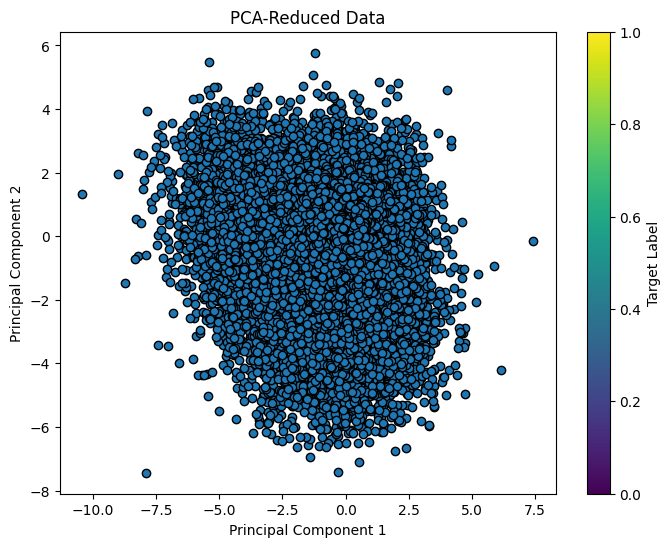

In [49]:
import matplotlib.pyplot as plt

# Scatter plot of the PCA-reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA-Reduced Data")
plt.colorbar(label="Target Label")
plt.show()



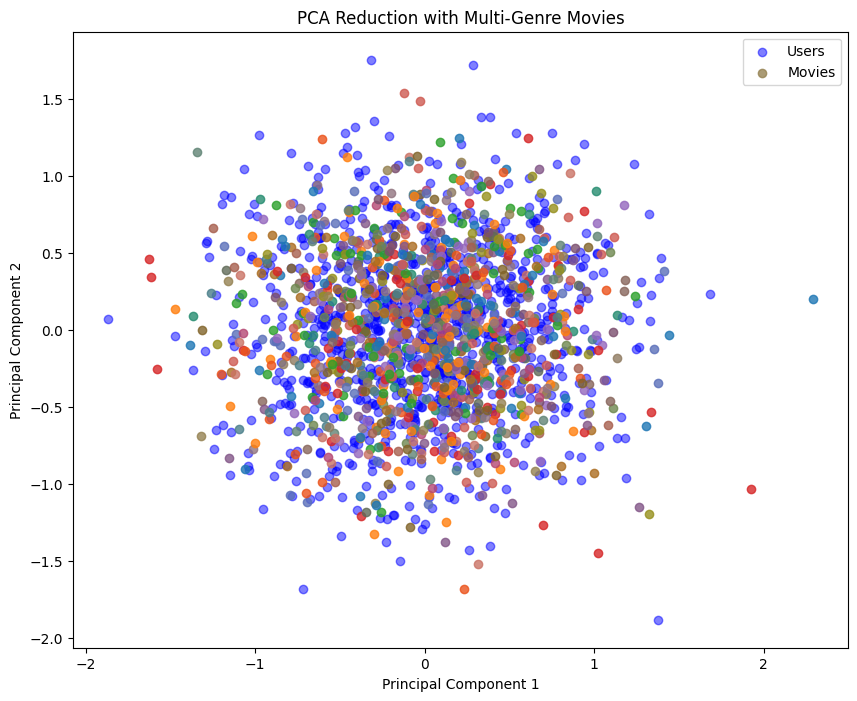

In [50]:

# Generate random latent factors for movies and users
movie_vectors = np.random.normal(loc=0, scale=1/2, size=(1050, 10))
user_vectors = np.random.normal(loc=0, scale=1/2, size=(1000, 10))

# Define genres and assign multiple genres per movie
genres_list = ['Action', 'Comedy', 'Drama', 'Horror', 'Sci-Fi']
np.random.seed(42)  # For reproducibility
movie_genres = [np.random.choice(genres_list, size=np.random.randint(1, 4), replace=False) for _ in range(1050)]

# Call the function to plot
plot_movie_user_pca(movie_vectors, movie_genres, user_vectors, genres_list)

In [51]:
SENSE_AND_SENSIBILITY = "17"
prediction_input = [("17", 4)] # Sense and Sensibility (1995)

###  Recommendations


In [52]:
HARRY_POTER = "267654"
LORD_OF_THE_RING = "279178"

In [53]:
SENSE_AND_SENSIBILITY = "17"

In [54]:
recommendations = recommender.recommend([(HARRY_POTER, 5)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Harry Poter (5-stared):")
pprint(recommendations)

'Recommendations for Harry Poter (5-stared):'
[{'features_count': 1,
  'features_hot_encoded': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Documentary'],
  'imdbId': 16116174,
  'title': 'Harry Potter 20th Anniversary: Return to Hogwarts (2022)',
  'tmdbId': 899082.0},
 {'features_count': 1,
  'features_hot_encoded': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Comedy'],
  'imdbId': 251654,
  'title': "Dave Chappelle: Killin' Them Softly (2000)",
  'tmdbId': 16275.0},
 {'features_count': 3,
  'features_hot_encoded': array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Action', 'Adventure', 'Comedy'],
  'imdbId': 118655,
  'title': 'Austin Powers: International Man of Mystery (1997)',
  'tmdbId': 816.0},
 {'features_count': 1,
  'features_hot_encoded': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Comedy'],
  'imdbId': 118826,
  'title': 'Castle, The (1997)

In [55]:
recommendations = recommender.recommend([(HARRY_POTER, 4)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Harry Poter (4-stared):")
pprint(recommendations)

recommendations = recommender.recommend([(HARRY_POTER, 4)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Harry Poter (4-stared):")
pprint(recommendations)


'Recommendations for Harry Poter (4-stared):'
[{'features_count': 1,
  'features_hot_encoded': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Documentary'],
  'imdbId': 16116174,
  'title': 'Harry Potter 20th Anniversary: Return to Hogwarts (2022)',
  'tmdbId': 899082.0},
 {'features_count': 2,
  'features_hot_encoded': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
  'genres': ['Drama', 'Romance'],
  'imdbId': 114388,
  'title': 'Sense and Sensibility (1995)',
  'tmdbId': 4584.0},
 {'features_count': 1,
  'features_hot_encoded': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Comedy'],
  'imdbId': 251654,
  'title': "Dave Chappelle: Killin' Them Softly (2000)",
  'tmdbId': 16275.0},
 {'features_count': 1,
  'features_hot_encoded': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'genres': ['Comedy'],
  'imdbId': 118826,
  'title': 'Castle, The (1997)',
  'tmdbId': 13852.0},
 {'featur

In [56]:
recommendations = recommender.recommend([(LORD_OF_THE_RING, 5)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Lord of the Ring (5-stared):")
pprint(recommendations)

2025-01-25 02:48:26,584 [INFO] The provided user ratings data contains the following unknown item rating(s), skipping unknown items' ratings [('279178', 5)]


MemoryError: Unable to allocate 126. GiB for an array with shape (200948, 84432) and data type float64

In [ ]:
recommendations = recommender.recommend([(LORD_OF_THE_RING, 4)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Lord of the Ring (4-stared):")
pprint(recommendations)

In [ ]:
# Ideally, the recommendation should not contain many "Lord of the Ring."
recommendations = recommender.recommend([(LORD_OF_THE_RING, 3)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Lord of the Ring (3-stared):")
pprint(recommendations)


In [ ]:
# We should not recommend "Lord of the Ring."
recommendations = recommender.recommend([(LORD_OF_THE_RING, 2)]) # [(MOVIE, RATING), ...]
pprint("Recommendations for Lord of the Ring (2-stared):")
pprint(recommendations)

Here is the corrected table:

| Sample size             | $\beta$   | $\lambda$ | $\gamma$ | $\tau$ | $k$  | Epochs | RMSE Train   | RMSE Test    | Loss Train       | Loss Test        | Recommendation |
|--------------------------|-----------|-----------|----------|--------|------|--------|--------------|--------------|------------------|------------------|----------------|
| 1,000,000               | None      | 5         | 0.2      | 0.5    | 10   | 10     | 0.6398357382 | 0.9573722035 | -859437.8237     | -497705.9132     | Not good       |
| 1,000,000               | None      | 0.5       | 0.01     | 0.4    | 10   | 20     | 0.6345867557 | 0.8798720925 | -87902.6796      | -45921.5971      | Not good       |
| 1,000,000               | None      | 1         | 0.04     | 0.4    | 10   | 20     | 0.6301793968 | 0.9039692663 | -171394.7980     | -94303.5198      | Not good       |
| 1,000,000               | None      | 0.5       | 0.1      | 0.1    | 10   | 20     | 0.6281751607 | 0.921288     | -90251.1060      | -53596.0488      | Not good       |
| 1,000,000               | None      | 0.1       | 0.1      | 0.1    | 10   | 20     | 0.6387279301 | 0.8667931235 | -23797.7348      | -15022.7668      | Not good       |
| 100,000,000,000,000,000 | None      | 5         | 0.2      | 0.5    | 10   | 10     | 0.7002276159 | 0.8106347909 | -32134423.5451   | -11279037.9697   | Not good       |
| 100,000,000,000,000,000 | None      | 0.1       | 0.01     | 0.1    | 10   | 20     | 0.6974530613 | 0.7876710025 | -662039.0551     | -237845.6851     | Got some same genre movie |
| 100,000,000,000,000,000 | None      | 0.1       | 0.1      | 0.1    | 10   | 20     | 0.7005592936 | 0.791084577  | -805758.7356     | -377689.7136     | Got some same genre movie |
| 100,000,000,000,000,000 | 10        | 0.1       | 0.1      | 0.1    | 30   | 20     | 0.6001383912 | 0.8438440669 | -636944.0774     | -403691.8737     | Good           |
| 100,000,000,000,000,000 | 10        | 0.5       | 0.01     | 0.5    | 10   | 20     | 0.6975553770 | 0.7890316677 | -3210830.2328    | -1092998.8915    | Got some same genre movie |
| 100,000,000,000,000,000 | 0.1       | 0.5       | 0.01     | 2      | 10   | 20     | 0.7040819727 | 0.781400124  | -3332430.7169    | -1137663.3828    | Got some same genre movie |

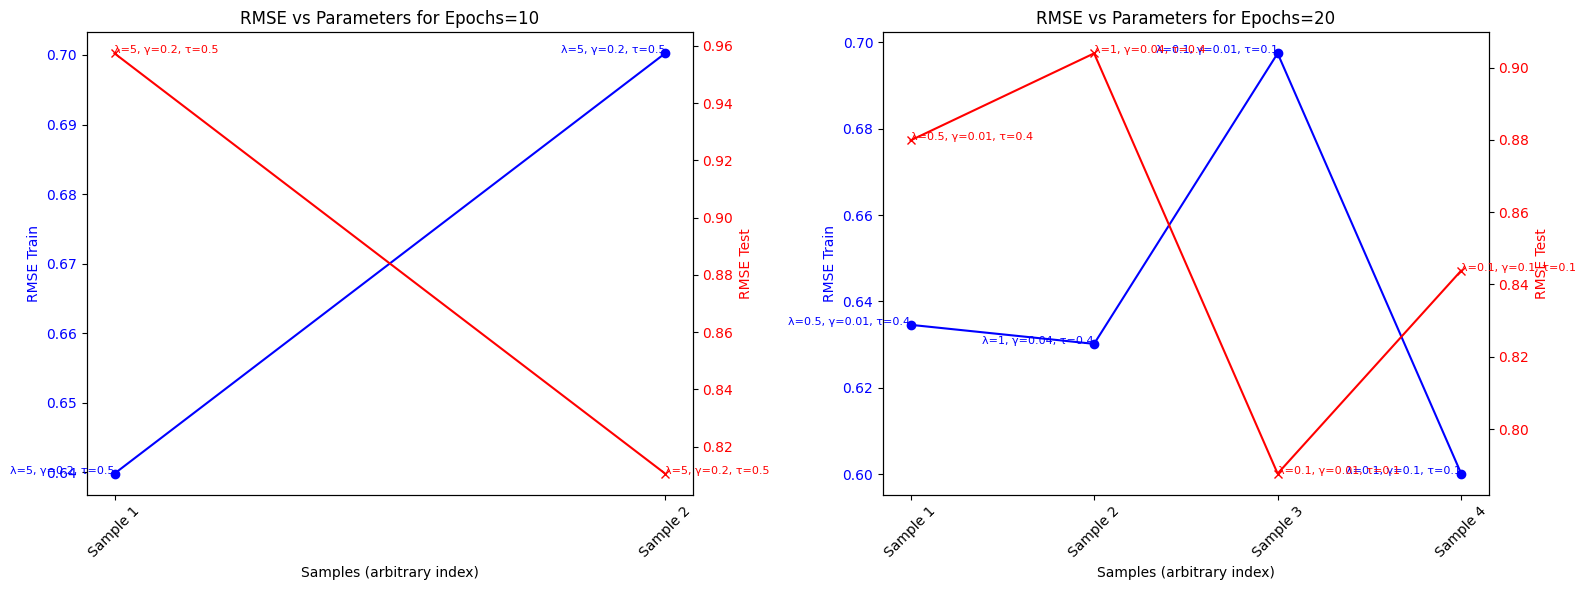

In [1]:
import matplotlib.pyplot as plt

# Data from the table
data = [
    # Sample size, β, λ, γ, τ, k, Epochs, RMSE Train, RMSE Test
    (1000000, None, 5, 0.2, 0.5, 10, 10, 0.6398357382, 0.9573722035),
    (1000000, None, 0.5, 0.01, 0.4, 10, 20, 0.6345867557, 0.8798720925),
    (1000000, None, 1, 0.04, 0.4, 10, 20, 0.6301793968, 0.9039692663),
    (32000204, None, 5, 0.2, 0.5, 10, 10, 0.7002276159, 0.8106347909),
    (32000204, None, 0.1, 0.01, 0.1, 10, 20, 0.6974530613, 0.7876710025),
    (32000204, 10, 0.1, 0.1, 0.1, 30, 20, 0.6001383912, 0.8438440669),
]

# Separate data by epochs
epochs_10 = [entry for entry in data if entry[6] == 10]
epochs_20 = [entry for entry in data if entry[6] == 20]

# Function to plot data for a specific epoch
def plot_rmse(data, epoch, ax):
    rmse_train = [entry[7] for entry in data]
    rmse_test = [entry[8] for entry in data]
    indices = range(len(data))

    # Plot RMSE Train on the left axis
    ax.plot(indices, rmse_train, label="RMSE Train", marker='o', color='blue')
    ax.set_ylabel("RMSE Train", color="blue")
    ax.tick_params(axis="y", labelcolor="blue")

    # Annotate RMSE Train with parameters
    for i, entry in enumerate(data):
        params = f"λ={entry[2]}, γ={entry[3]}, τ={entry[4]}"
        ax.text(i, rmse_train[i], params, fontsize=8, color="blue", ha="right")

    # Plot RMSE Test on the right axis
    ax2 = ax.twinx()
    ax2.plot(indices, rmse_test, label="RMSE Test", marker='x', color='red')
    ax2.set_ylabel("RMSE Test", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Annotate RMSE Test with parameters
    for i, entry in enumerate(data):
        params = f"λ={entry[2]}, γ={entry[3]}, τ={entry[4]}"
        ax2.text(i, rmse_test[i], params, fontsize=8, color="red", ha="left")

    # Set title and x-axis labels
    ax.set_title(f"RMSE vs Parameters for Epochs={epoch}")
    ax.set_xlabel("Samples (arbitrary index)")
    ax.set_xticks(indices)
    ax.set_xticklabels([f"Sample {i+1}" for i in indices], rotation=45)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot for epochs=10
plot_rmse(epochs_10, 10, axes[0])

# Plot for epochs=20
plot_rmse(epochs_20, 20, axes[1])

plt.tight_layout()
plt.show()


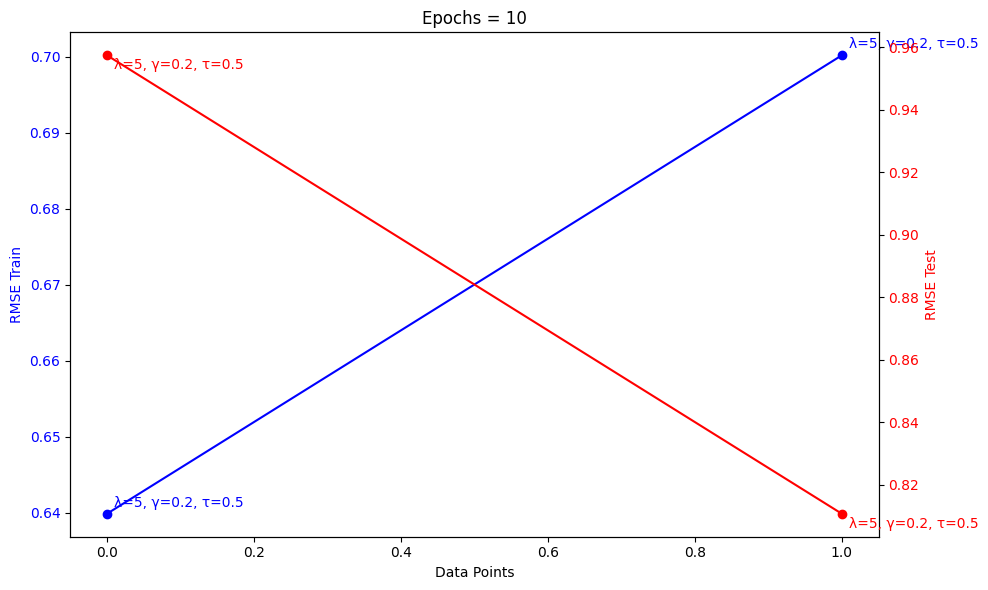

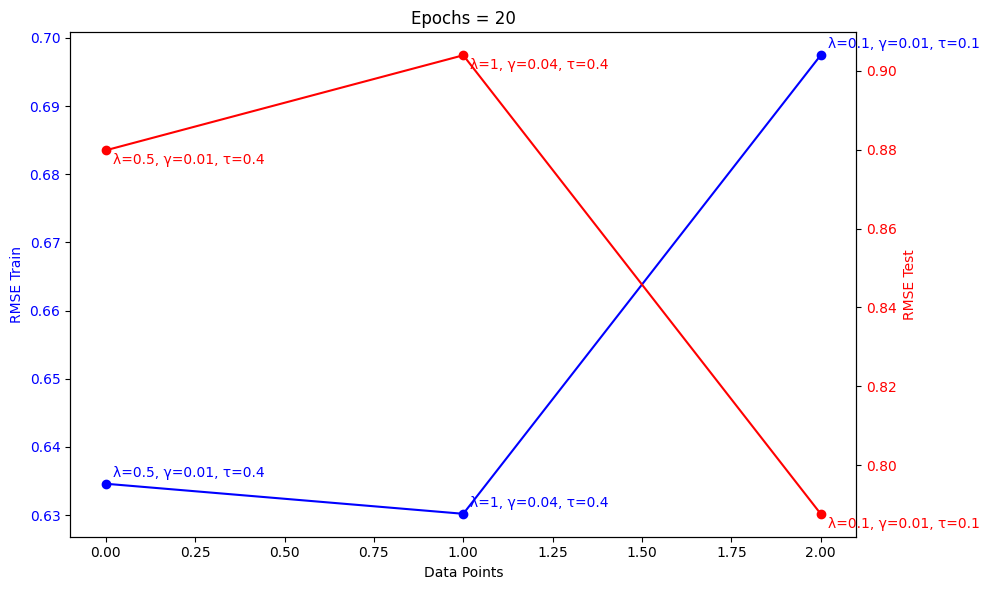

In [2]:
import matplotlib.pyplot as plt

# Data for epochs = 10
epochs_10 = {
    "RMSE Train": [0.6398357382, 0.7002276159],
    "RMSE Test": [0.9573722035, 0.8106347909],
    "Parameters": [
        "λ=5, γ=0.2, τ=0.5",
        "λ=5, γ=0.2, τ=0.5"
    ]
}

# Data for epochs = 20
epochs_20 = {
    "RMSE Train": [0.6345867557, 0.6301793968, 0.6974530613],
    "RMSE Test": [0.8798720925, 0.9039692663, 0.7876710025],
    "Parameters": [
        "λ=0.5, γ=0.01, τ=0.4",
        "λ=1, γ=0.04, τ=0.4",
        "λ=0.1, γ=0.01, τ=0.1"
    ]
}

# Function to plot
def plot_rmse(data, epoch, ax_title):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot RMSE Train
    ax1.plot(data["RMSE Train"], marker="o", color="blue", label="RMSE Train")
    ax1.set_ylabel("RMSE Train", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Annotate points for RMSE Train
    for i, txt in enumerate(data["Parameters"]):
        ax1.annotate(txt, (i, data["RMSE Train"][i]), color="blue", xytext=(5, 5), textcoords="offset points")

    # Create second y-axis
    ax2 = ax1.twinx()
    ax2.plot(data["RMSE Test"], marker="o", color="red", label="RMSE Test")
    ax2.set_ylabel("RMSE Test", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Annotate points for RMSE Test
    for i, txt in enumerate(data["Parameters"]):
        ax2.annotate(txt, (i, data["RMSE Test"][i]), color="red", xytext=(5, -10), textcoords="offset points")

    # Title and labels
    plt.title(ax_title)
    ax1.set_xlabel("Data Points")

    plt.tight_layout()
    plt.show()

# Plot for epochs = 10
plot_rmse(epochs_10, epoch=10, ax_title="Epochs = 10")

# Plot for epochs = 20
plot_rmse(epochs_20, epoch=20, ax_title="Epochs = 20")
